# Machine Learning for Demand Forecasting

# 1 Import Data

In [3]:
# Import dataset
import numpy as np
import pandas as pd
import sklearn
import xgboost
import matplotlib.pyplot as plt

In [4]:
# Import dataset to dataframe
def import_data():
    data = pd.read_csv('dataset.csv')
    
    # z.fill(x) adds leading zeros to a string until it reaches a length of x.
    data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2) 
    df = pd.pivot_table(data=data, values='Demand', index='Product', columns='Period',
                         aggfunc='sum', fill_value=0)
    return df


# Build an appropriate dataframe for our machine learning
def datasets(df, x_len=12, y_len=1, test_loops=12):
    D = df.values
    rows, periods = D.shape
    
    # Training set creation
    loops = periods + 1 - x_len - y_len
    train = []
    for col in range(loops):
        train.append(D[:, col:col+x_len+y_len])
    train = np.vstack(train)
    X_train, Y_train = np.split(train, [-y_len], axis=1)
    
    # Test set creation
    # np.split(array, indices, axis): cuts an array at specific indices along an axis
    if test_loops > 0:
        X_train, X_test = np.split(X_train, [-rows*test_loops], axis=0) 
        Y_train, Y_test = np.split(Y_train, [-rows*test_loops], axis=0)
    
    # No test set
    # X_test is used to generate the future forecast
    else: 
        X_test = D[:, -x_len:]
        Y_test = np.full((X_test.shape[0], y_len), np.nan)
    
    # Formatting required for scikit-learn
    # array.ravel(): reduces the dimension of a Numpy array to 1D.
    if y_len == 1:
        Y_train = Y_train.ravel() 
        Y_test = Y_test.ravel()

    return X_train, Y_train, X_test, Y_test

# We can now easily call our new functions
df = import_data()
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=1, test_loops=12)
print(df)

# Note that we set test_loops as 12 periods.
# That means that we will test our algorithm over 12 different loops.
# We will predict 12 times the following period [y_len=1] based on the last 12 periods [x_len=12]).

# We obtain the datasets we need to traing our machine learning algorithm (X_train and Y_train)
# and the datasets we need to test it (X_test and Y_test)

Period      2007-01  2007-02  2007-03  2007-04  2007-05  2007-06  2007-07  \
Product                                                                     
Product 1      2884     1885     1833     1300     1866     1620     1901   
Product 10      362      410      387      387      422      421      469   
Product 11      352      335      365      360      431      477      403   
Product 12      263      247      239      179      223      277      281   
Product 13      258      264      333      347      420      262      296   
...             ...      ...      ...      ...      ...      ...      ...   
Product 65        0        0        0        0        0        0        0   
Product 66        0        0        0        0        0        0        0   
Product 7       622      551      578      534      771      683      685   
Product 8       599      498      682      556      630      498      562   
Product 9       423      356      399      351      520      624      401   

# 2 Forecast KPI Function

In [68]:
# Forecast KPI Function
def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=''):
    df = pd.DataFrame(columns = ['MAE', 'RMSE', 'Bias'], index=['Train', 'Test'])
    df.index.name = name
    df.loc['Train','MAE'] =   100*np.mean(abs(Y_train - Y_train_pred))/np.mean(Y_train)
    df.loc['Train', 'RMSE'] = 100*np.sqrt(np.mean((Y_train - Y_train_pred)**2))/np.mean(Y_train)
    df.loc['Train', 'Bias'] = 100*np.mean((Y_train - Y_train_pred))/np.mean(Y_train)
    df.loc['Test', 'MAE'] =   100*np.mean(abs(Y_test - Y_test_pred))/np.mean(Y_test)
    df.loc['Test', 'RMSE'] =  100*np.sqrt(np.mean((Y_test - Y_test_pred)**2))/np.mean(Y_test)
    df.loc['Test', 'Bias'] =  100*np.mean((Y_test - Y_test_pred))/np.mean(Y_test)
    df = df.astype(float).round(1) # Round number for display
    print(df)

# 3 Linear Regression

In [69]:
# Linear Regression Function
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

# Fit the linear regression to the training data
reg = reg.fit(X_train, Y_train)

# Create predictions for the training and test sets
Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)

# Measure its accuracy
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Linear Regression')

                    MAE  RMSE  Bias
Linear Regression                  
Train              17.9  44.2  -0.0
Test               17.8  44.0   1.6


# 4 Tree

In [70]:
# Decision Tree Regressor Function
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=5, min_samples_split=15, min_samples_leaf=5)

# Fit the tree to the training data
tree = tree.fit(X_train, Y_train)

# Create predictions for the training and test sets
Y_train_pred = tree.predict(X_train)
Y_test_pred = tree.predict(X_test)

# Measure its accuracy
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Tree')


        MAE  RMSE  Bias
Tree                   
Train  18.1  43.7  -0.0
Test   21.1  53.0   3.2


# 4.1 MAE vs RMSE
Thanks to scikit-learn we can choose to build our tree in a way that minimizes one or the other (thanks to the parameter 'criterion').
Let’s record how long it takes to optimize a tree that minimizes MAE and another one that minimizes MSE (most of the machine learning algorithms optimize the mean square error [MSE] rather than the root mean square error, as it is easier to compute and manipulate). In order to do so, we will use the time library, which can give us the current time via time.time().

In [71]:
import time
for criterion in ['squared_error', 'absolute_error']: # mse ~= 'squared_error'. mae='absolute_error'
    start_time = time.time()
    tree = DecisionTreeRegressor(max_depth=5, min_samples_split=15, min_samples_leaf=5, criterion=criterion)
    
    # Fit the tree to the training data
    tree.fit(X_train, Y_train)
    
    # Create predictions for the training and test sets
    Y_train_pred = tree.predict(X_train)
    Y_test_pred = tree.predict(X_test)

    # Measure its accuracy
    kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=f'Tree {criterion}')
    print('{:0.2f} seconds'.format(time.time()-start_time))
    print()

                     MAE  RMSE  Bias
Tree squared_error                  
Train               18.1  43.7  -0.0
Test                21.1  53.0   3.2
0.02 seconds

                      MAE  RMSE  Bias
Tree absolute_error                  
Train                17.9  47.4   2.3
Test                 21.5  59.0   5.2
1.05 seconds



# 4.2. Plotting Tree

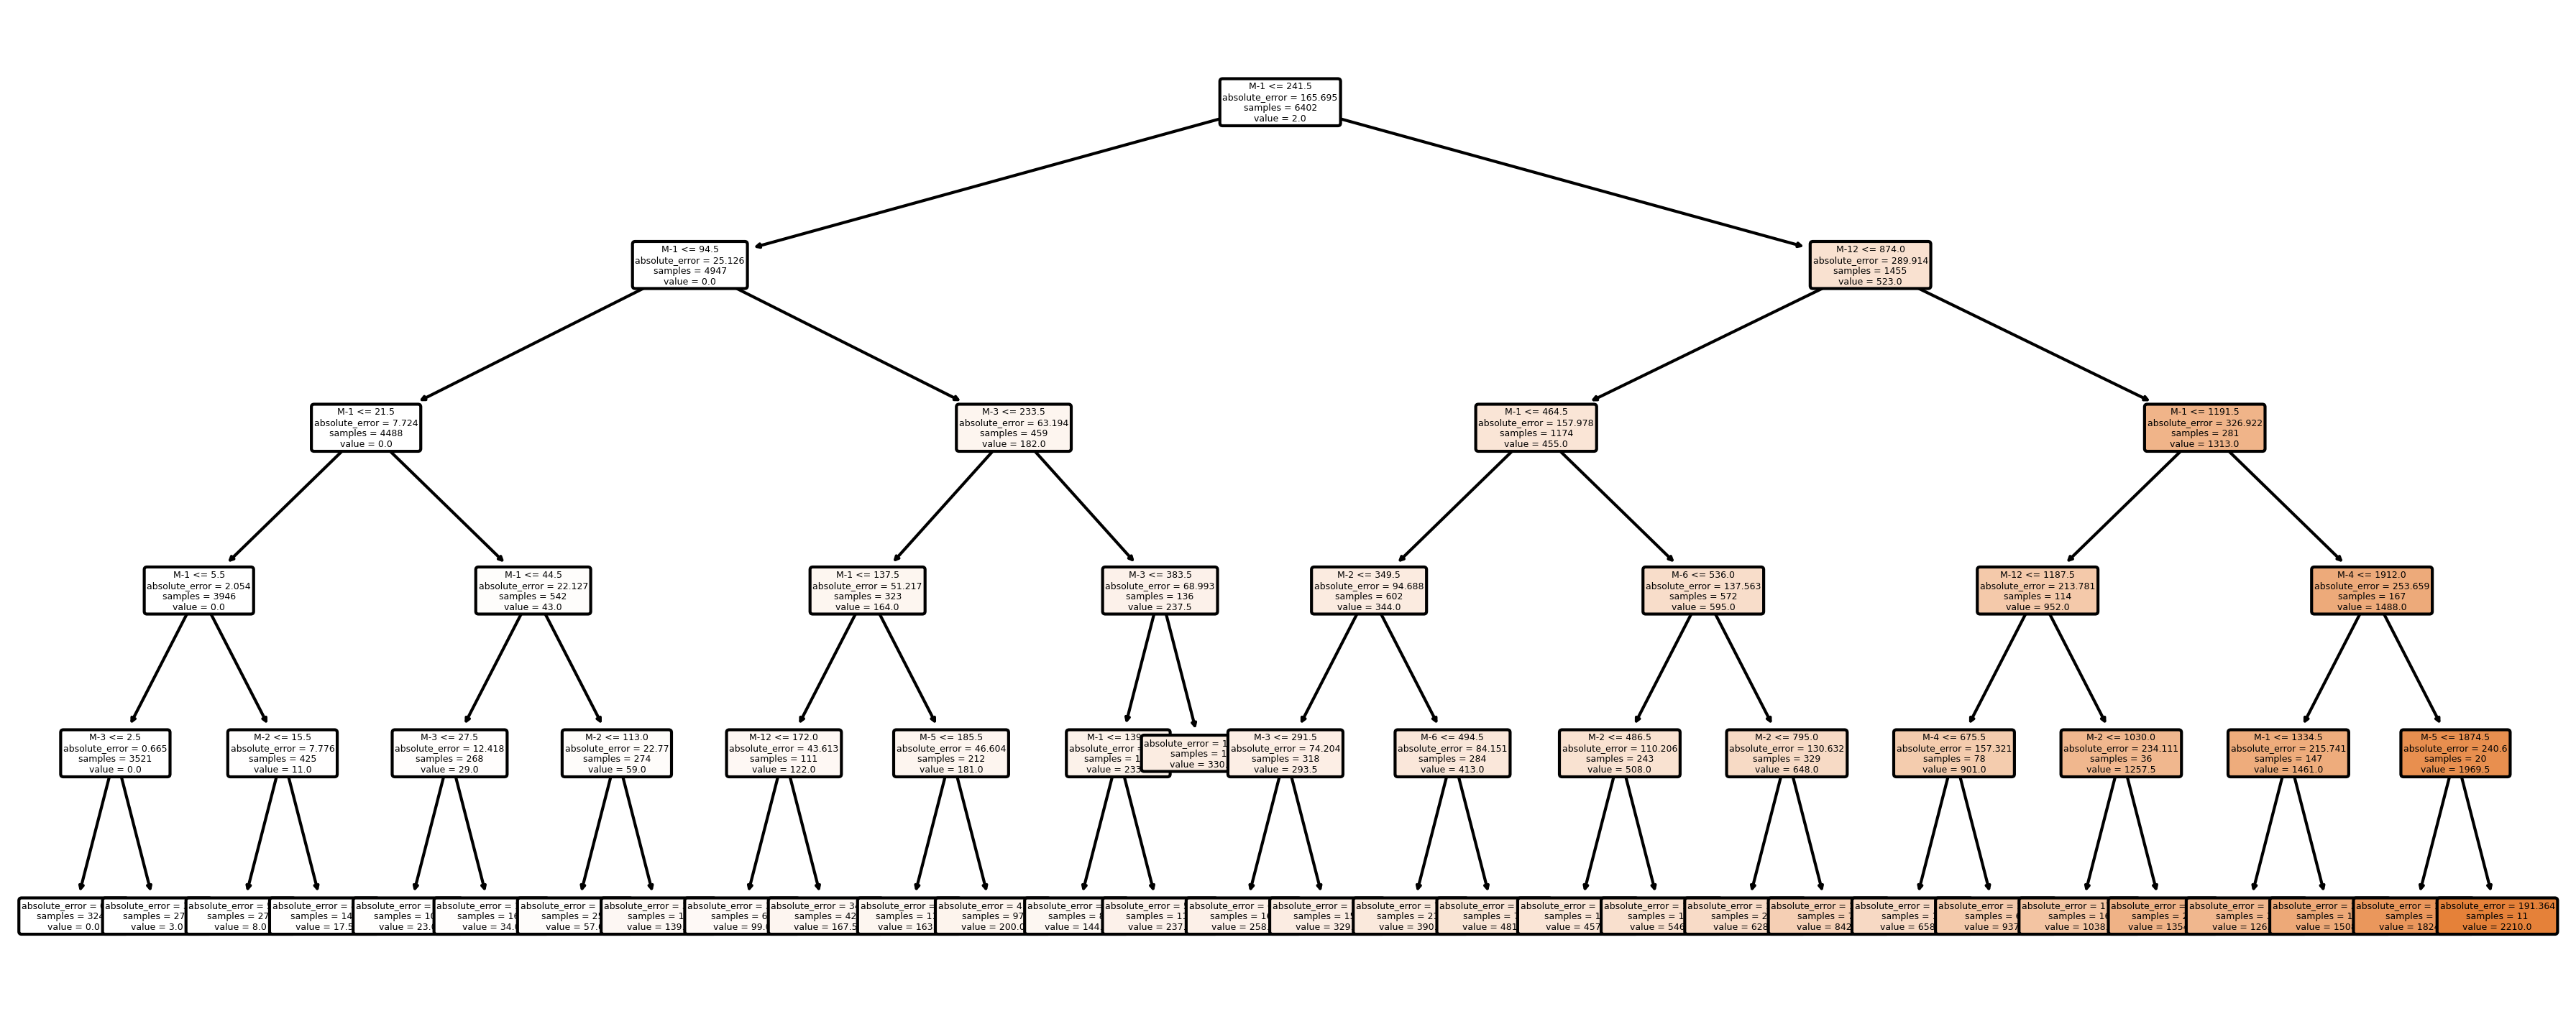

In [72]:
# Plotting our tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,6), dpi=300)
ax = fig.gca()

plot_tree(tree, fontsize=3, feature_names=[f'M{x-12}' for x in range(12)], rounded=True, filled=True, ax=ax)
fig.savefig('Regression Tree.PNG')

# 4.3. Tree Optimization
# Smart Experiments:
- k-fold Cross-validation: to avoid overfitting
- Random Search: to efficiently find a (very) good parameter set among different possibilities
    - Grid Search
    - Random Search

In [73]:
# k-fold Cross-validation to avoid overfitting (cv parameter)
# Random Search to efficiently find a very good parameter set among different possibilites

max_depth = list(range(5,11)) + [None]
min_samples_split = range(5,20)
min_samples_leaf = range(2,20)

param_dist = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

# Test all these different parameter sets against our training set
from sklearn.model_selection import RandomizedSearchCV
tree = DecisionTreeRegressor()
tree_cv = RandomizedSearchCV(tree, param_dist, cv=10, n_jobs=-1, verbose=1, n_iter=100, scoring='neg_mean_absolute_error')

# Fit the tree to the training data
tree_cv.fit(X_train, Y_train)
print('Tuned Regression Tree Parameters:', tree_cv.best_params_)

# Create predictions for the training and test sets
Y_train_pred = tree_cv.predict(X_train)
Y_test_pred = tree_cv.predict(X_test)

# Measure its accuracy
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Tree Optimization')

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Tuned Regression Tree Parameters: {'min_samples_split': 10, 'min_samples_leaf': 13, 'max_depth': 7}
                    MAE  RMSE  Bias
Tree Optimization                  
Train              16.4  40.3  -0.0
Test               19.2  47.6   3.0


# 5 Forest

In [74]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(bootstrap=True, max_samples=0.95, max_features=11, min_samples_leaf=18, max_depth=7)

# Fit he forest to the training data
forest.fit(X_train, Y_train)

# Create predictions for the training and test sets
Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)

# Measure its accuracy
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest')

         MAE  RMSE  Bias
Forest                  
Train   15.7  40.5   0.1
Test    18.5  48.0   3.9


# 5.1 Forest Optimization

In [75]:
# k-fold Cross-validation to avoid overfitting (cv parameter)
# Random Search to efficiently find a very good parameter set among different possibilites

max_depth = list(range(5,11)) + [None]
min_samples_split = range (5,20)
min_samples_leaf = range (2,15)

# Bootstrap means that each tree will receive a random selection from the initial training dataset
# max_samples means to limit the amount of data given to each tree
# max_features means to limit the maximum number of features that the algorithm can choose from each node and
# the features are choosen randomly each time, we will obtain different trees at each fitting.
bootstrap = [True] #We force bootstrap
max_samples = [.7, .8, .9, .95, 1]
max_features = range(3,8)

param_dist = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap,
              'max_samples': max_samples,
              'max_features': max_features}

# Test all these different parameter sets against our training set
from sklearn.model_selection import RandomizedSearchCV
forest = RandomForestRegressor(n_jobs=1, n_estimators=30)
forest_cv = RandomizedSearchCV(forest, param_dist, cv=6, n_jobs = -1, verbose=1, n_iter=400, scoring='neg_mean_absolute_error')

# Fit the forest to the training data
forest_cv.fit(X_train, Y_train)
print('Tuned Forest Parameters:', forest_cv.best_params_)

# Create predictions for the training and test sets
Y_train_pred = forest_cv.predict(X_train)
Y_test_pred = forest_cv.predict(X_test)

# Measure the accuracy
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest Optimization')

Fitting 6 folds for each of 400 candidates, totalling 2400 fits
Tuned Forest Parameters: {'min_samples_split': 19, 'min_samples_leaf': 10, 'max_samples': 0.7, 'max_features': 6, 'max_depth': 10, 'bootstrap': True}
                      MAE  RMSE  Bias
Forest Optimization                  
Train                15.0  39.0   0.2
Test                 18.3  47.3   3.5


# 5.2. Number of Trees in the Forest
In order to get the best out of our forest—without increasing computation time too much—let’s run a forest with our new optimal parameters and n_estimators=200. We can easily allow ourselves 200 trees due to the dataset limited size

In [76]:
forest = RandomForestRegressor(n_jobs=-1, n_estimators=200, **forest_cv.best_params_)

# Fit the forest to the training data
forest = forest.fit(X_train, Y_train)

# Create predictions for the training and test sets
Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)

# Measure the accuracy
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forestx200')

             MAE  RMSE  Bias
Forestx200                  
Train       14.8  38.4  -0.0
Test        17.9  46.2   3.0


# 6 Extremely Randomized Trees
The random forest idea was that we could obtain a better forecast accuracy by taking the average prediction of many different trees.

In [77]:
from sklearn.ensemble import ExtraTreesRegressor
ETR = ExtraTreesRegressor(n_jobs=-1, n_estimators=200, min_samples_split=15, min_samples_leaf=4, max_samples=0.95,
                         max_features=4, max_depth=8, bootstrap=True)

# Fit the ExtraTreesRegressor to the training data
ETR.fit(X_train,Y_train)

# Create predictions for the training and test sets
Y_train_pred = ETR.predict(X_train)
Y_test_pred = ETR.predict(X_test)

# Measure the accuracy
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='ETR')

        MAE  RMSE  Bias
ETR                    
Train  17.8  43.7   0.1
Test   18.7  47.1   3.3


# 6.1. Extremely Randomized Trees Optimization

In [78]:
# k-fold Cross-validation to avoid overfitting (cv parameter)
# Random Search to efficiently find a very good parameter set among different possibilites

max_depth = list(range(6, 13)) + [None]
min_samples_split = range(7,16)
min_samples_leaf = range(2,13)

# Bootstrap means that each tree will receive a random selection from the initial training dataset
# max_samples means to limit the amount of data ggiven to each tree
# max_features means to limit the maximum number of features that the algorithm can choose from each node and
# the features are choosen randomly each time, we will obtain different trees at each fitting.
bootstrap = [True] # We force bootstrap
max_samples = [.7, .8, .9, .95, 1]
max_features = range(5,13)

param_dist = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap,
              'max_samples': max_samples,
              'max_features': max_features}

# Test all these different parameter sets against our training set
ETR = ExtraTreesRegressor(n_jobs=1, n_estimators=30)
ETR_cv = RandomizedSearchCV(ETR, param_dist, cv=5, n_jobs=-1, verbose=1, n_iter=400, scoring='neg_mean_absolute_error')

# Fit the forest to the training data
ETR_cv.fit(X_train, Y_train)
print('Tuned Forest Parameters', ETR_cv.best_params_)

# Create predictions for the training and test sets
Y_train_pred = ETR_cv.predict(X_train)
Y_test_pred = ETR_cv.predict(X_test)

# Measure the accuracy
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='ETR Optimization')

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Tuned Forest Parameters {'min_samples_split': 14, 'min_samples_leaf': 2, 'max_samples': 0.9, 'max_features': 9, 'max_depth': 12, 'bootstrap': True}
                   MAE  RMSE  Bias
ETR Optimization                  
Train             14.7  37.3   0.1
Test              17.9  46.8   3.0


# 6.2. Number of Trees in the Extremely Randomized Trees

In order to get the best out of our ETR, let's run a ETR with our new optimal parameters and n_estimators=200. We can easily allow ourselves 200 trees due to the dataset limited size

In [79]:
ETR = ExtraTreesRegressor(n_jobs=-1, n_estimators=200, **ETR_cv.best_params_)

# Fit the ETR to the training data
ETR = ETR.fit(X_train, Y_train)

# Create predictions for the training and test sets
Y_train_pred = ETR.predict(X_train)
Y_test_pred = ETR.predict(X_test)

# Measure the accuracy
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='ETRx200')

          MAE  RMSE  Bias
ETRx200                  
Train    14.5  36.9  -0.1
Test     17.6  45.0   2.6


# 7 Feature Importance
The feature importance is measured as the forecast accuracy (down) brought by each feature.
The feature importance is then normalized (is scaled so that the sum of all features importance is 1).

<AxesSubplot:>

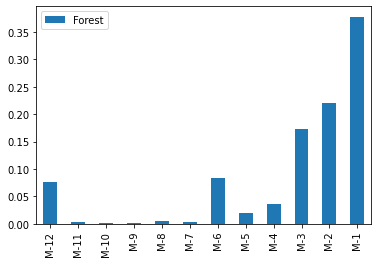

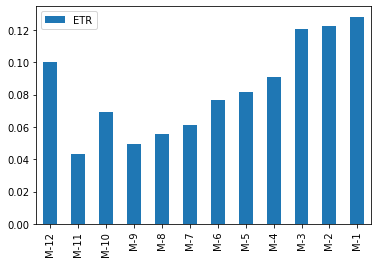

In [80]:
cols = X_train.shape[1] #number of columns in our training sets
features = [f'M-{cols-col}' for col in range(cols)]

# We can then extract the feature importance from our forest model, thanks to its attribute feature_importances and reshape this to a vertical array (thanks to reshape(-1,1))
data = forest.feature_importances_.reshape(-1,1)
# We can then save these features and their respective importance into a DataFrame
imp_forest = pd.DataFrame(data=data, index=features, columns=['Forest'])

# We can then extract the feature importance from our ETR model, thanks to its attribute feature_importances and reshape this to a vertical array (thanks to reshape(-1,1))
data = ETR.feature_importances_.reshape(-1,1)
# We can then save these features and their respective importance into a DataFrame
imp_ETR = pd.DataFrame(data=data, index=features, columns=['ETR'])


# Finally, we can simply plot it and obtain a figure
imp_forest.plot(kind='bar')
imp_ETR.plot(kind='bar')

# 8. Feature Optimization
So far, we have created tree different models:

1. A regression tree
2. A random forest
3. A set of extremely randomized trees

We have optimized each of them via:
1. A random search automatically running through some possible parameter sets
2. Testing them via k-fold cross validation

There is one thing that we haven't optimized (yet): the features that we use.

#### What if we used 13 months insted of 12 to make a forecast?

# 8.1. Feature Optimization Idea #1 - Training Set

Model
ETR Test        12
ETR Train       42
Forest Test     12
Forest Train    42
dtype: int64


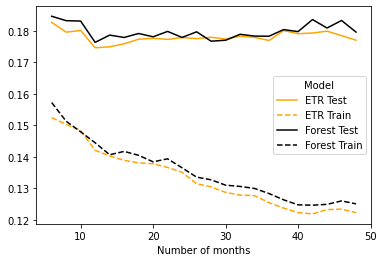

In [81]:
df = import_data()

forest_features = {'n_jobs':-1, 'n_estimators':200, 'min_samples_split':15, 'min_samples_leaf': 4, 'max_samples': 0.95,
                   'max_features':0.3, 'max_depth':8, 'bootstrap':True}
forest = RandomForestRegressor(**forest_features)

ETR_features = {'n_jobs':-1, 'n_estimators':200, 'min_samples_split':14, 'min_samples_leaf':2, 'max_samples':0.9,
                'max_features':1.0, 'max_depth':12, 'bootstrap':True}
ETR = ExtraTreesRegressor(**ETR_features)

models = [('Forest',forest), ('ETR',ETR)]

# Note that you have to set max_features as a ratio and not as an absolute number
# (remember, scikit-learn will interpret 1.0 as “Use all features” and not as “Use 1 feature”).

# We will also define a function model_mae() that will return the mean absolute
# error obtained by a model against a dataset Y.

def model_mae(model, X, Y):
    Y_pred = model.predict(X)
    mae = np.mean(np.abs(Y-Y_pred))/np.mean(Y)
    return mae

# We are now ready to loop through all the possible historical horizons.

n_months = range(6,50, 2)
results = []
for x_len in n_months: # We loop through the different x_len
    X_train, Y_train, X_test, Y_test = datasets(df, x_len=x_len)
    for name, model in models: # We loop through the models
        model.fit(X_train, Y_train)
        mae_train = model_mae(model, X_train, Y_train)
        mae_test = model_mae(model, X_test, Y_test)
        results.append([name+' Train', mae_train, x_len])
        results.append([name+' Test', mae_test, x_len])
        
# We now have a list (results) that contains all our results
data = pd.DataFrame(results, columns=['Model', 'MAE%', 'Number of Months'])
data = data.set_index(['Number of Months', 'Model']).stack().unstack('Model')
data.index = data.index.droplevel(level=1)
data.index.name = 'Number of months'

# We can then simply plot data using the method .plot() 
data.plot(color=['orange']*2+['black']*2, style=['-','--']*2)

# You can also populate a summary table with the optimal number of months that was obtained on each dataset
print(data.idxmin())

# 8.2. Feature Optimization Idea #2 - Validation Set

Model
ETR Test        12
ETR Train       44
ETR Val         42
Forest Test     30
Forest Train    40
Forest Val      42
dtype: int64


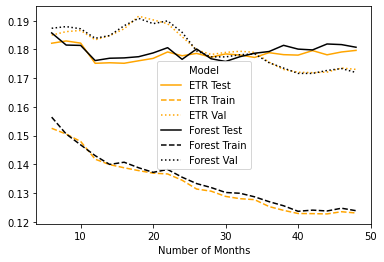

In [82]:
from sklearn.model_selection import KFold
n_months = range(6,50, 2)
results = []
for x_len in n_months:
    X_train, Y_train, X_test, Y_test = datasets(df, x_len=x_len)
    for name,model in models:
        mae_kfold_train = []
        mae_kfold_val = []
        for train_index, val_index in KFold(n_splits=8).split(X_train):
            X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
            Y_train_kfold, Y_val_kfold = Y_train[train_index], Y_train[val_index]
            model.fit(X_train_kfold, Y_train_kfold)
            mae_train = model_mae(model, X_train_kfold, Y_train_kfold)
            mae_kfold_train.append(mae_train)
            mae_val = model_mae(model, X_val_kfold, Y_val_kfold)
            mae_kfold_val.append(mae_val)
        results.append([name+' Train', np.mean(mae_kfold_train), x_len])
        results.append([name+' Val', np.mean(mae_kfold_val), x_len])
        
        model.fit(X_train, Y_train)
        mae_test = model_mae(model, X_test, Y_test)
        results.append([name+' Test', mae_test, x_len])
        
# We can also clean our results in order to plot them.
data = pd.DataFrame(results, columns=['Model', 'MAE%', 'Number of Months'])
data = data.set_index(['Number of Months', 'Model']).stack().unstack('Model')
data.index = data.index.droplevel(level=1)
data.index.name = 'Number of Months'
data.plot(color=['orange']*3+['black']*3, style=['-','--',':']*3)
print(data.idxmin())

# 8.3. Feature Optimization Idea # 3 - Holdout Dataset

Model
ETR Holdout       20
ETR Test          14
ETR Train         42
Forest Holdout    18
Forest Test       12
Forest Train      40
dtype: int64


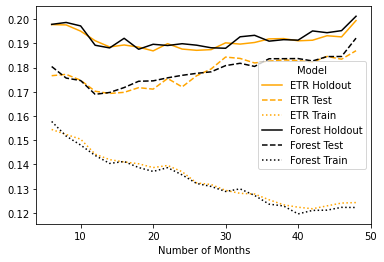

In [84]:
def datasets_holdout(df, x_len=12, y_len=1, test_loops=12, holdout_loops=0):
    D = df.values
    rows, periods = D.shape
    
    # Training set creation
    train_loops = periods + 1 - x_len - y_len - test_loops
    train = []
    for col in range(train_loops):
        train.append(D[:,col:col+x_len+y_len])
    train = np.vstack(train)
    X_train, Y_train = np.split(train, [-y_len], axis=1)
    
    # Holdout set creation
    if holdout_loops > 0:
        X_train, X_holdout = np.split(X_train, [-rows*holdout_loops], axis=0)
        Y_train, Y_holdout = np.split(Y_train, [-rows*holdout_loops], axis=0)
    else:
        X_holdout, Y_holdout = np.array([]), np.array([])
        
    # Test set creation
    if test_loops > 0:
        X_train, X_test = np.split(X_train, [-rows*test_loops], axis=0)
        Y_train, Y_test = np.split(Y_train, [-rows*test_loops], axis=0)
    else: # No test set: X_test is used to generate the feature forescast
        X_test = D[:, -x_len:]
        Y_test = np.full((X_test.shape[0], y_len), np.nan) # Dummy value
        
    # Formatting required for scikit-learn
    if y_len == 1:
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()
        Y_holdout = Y_holdout.ravel()
        
    return X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test

# We can now use this new function in our main loop
results = []
for x_len in n_months:
    X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test = datasets_holdout(df, x_len=x_len, holdout_loops=12)
    for name, model in models:
        model.fit(X_train, Y_train)
        mae_train = model_mae(model, X_train, Y_train)
        mae_holdout = model_mae(model, X_holdout, Y_holdout)
        mae_test = model_mae(model, X_test, Y_test)
        results.append([name+' Train', mae_train, x_len])
        results.append([name+' Holdout', mae_holdout, x_len])
        results.append([name+' Test', mae_test, x_len])
        
# We can also plot the results
data = pd.DataFrame(results, columns=['Model', 'MAE%', 'Number of Months'])
data = data.set_index(['Number of Months', 'Model']).stack().unstack('Model')
data.index = data.index.droplevel(level=1)
data.index.name = 'Number of Months'
data.plot(color=['orange']*3+['black']*3, style=['-', '--', ':']*3)
print(data.idxmin())

# 9 Adaptative Boosting (AdaBoost)

In [85]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=100, learning_rate=0.25, loss='square')

# Fit the AdaBoost to the training data
ada = ada.fit(X_train, Y_train)

# Create predictions or the training and test sets
Y_train_pred = ada.predict(X_train)
Y_test_pred = ada.predict(X_test)

# Measure the accuracy
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='AdaBoost')

           MAE  RMSE  Bias
AdaBoost                  
Train      4.8  10.4   0.0
Test      19.4  51.3  -0.2


# 9.1. Adaptative Boosting (AdaBoost) Optimization

In [86]:
# n_estimators = [100]
learning_rate = [0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35]
loss = ['square', 'exponential', 'linear']
param_dist = {#'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'loss': loss}

def model_mae(model, X, Y):
    Y_pred = model.predict(X)
    mae = np.mean(np.abs(Y - Y_pred))/np.mean(Y)
    return mae
# Let's now go into our optimization loop.
# for each max_depth tried by using ada_cv.best_score and ada_cv.best_params_

from sklearn.model_selection import RandomizedSearchCV
results = [] # To record the best score and parameters obtained

for max_depth in range(2,18,2):
    ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth))
    ada_cv = RandomizedSearchCV(ada, param_dist, n_jobs=-1, cv=6, n_iter=20, scoring='neg_mean_absolute_error')
    ada_cv.fit(X_train, Y_train)
    print('Tuned AdaBoost Parameters:', ada_cv.best_params_)
    print('Result:', ada_cv.best_score_)
    results.append([ada_cv.best_score_, ada_cv.best_params_, max_depth])

# We can then transform results into a DataFrame
# The method idxmax() on our DataFrame to print the parameter set that got the lowest error
# RandomizedSearchCV is returning the negative mean absolute error.

results = pd.DataFrame(data=results, columns=['Score', 'Best Params', 'Max_Depth'])
optimal = results['Score'].idxmax()
print(results.iloc[optimal])

Tuned AdaBoost Parameters: {'loss': 'exponential', 'learning_rate': 0.05}
Result: -48.76670895225832
Tuned AdaBoost Parameters: {'loss': 'linear', 'learning_rate': 0.005}
Result: -32.303649402859755
Tuned AdaBoost Parameters: {'loss': 'exponential', 'learning_rate': 0.005}
Result: -30.870774341191993
Tuned AdaBoost Parameters: {'loss': 'linear', 'learning_rate': 0.1}
Result: -31.00338216882832
Tuned AdaBoost Parameters: {'loss': 'linear', 'learning_rate': 0.1}
Result: -31.3885611173568
Tuned AdaBoost Parameters: {'loss': 'exponential', 'learning_rate': 0.05}
Result: -31.138851216302204
Tuned AdaBoost Parameters: {'loss': 'linear', 'learning_rate': 0.05}
Result: -31.509728407652478
Tuned AdaBoost Parameters: {'loss': 'exponential', 'learning_rate': 0.1}
Result: -31.07390500384214
Score                                               -30.870774
Best Params    {'loss': 'exponential', 'learning_rate': 0.005}
Max_Depth                                                    6
Name: 2, dtype: objec

In [87]:
# Test the optimal parameter found against our training set 
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=6),
                        n_estimators=100,
                        learning_rate=0.01,
                        loss='linear')

# Fit the AdaBoost to the traiing data
ada.fit(X_train, Y_train)

# Create predictions for the training and test sets
Y_train_pred = ada.predict(X_train)
Y_test_pred = ada.predict(X_test)

# Measure the accuracy
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='AdaBoost optimized')

                     MAE  RMSE  Bias
AdaBoost optimized                  
Train                9.9  22.0   0.4
Test                19.1  51.1   0.3


# # 9.2. Adaptative Boosting (AdaBoost) Forecast

In [88]:
# Multiple Output Periods
from sklearn.multioutput import MultiOutputRegressor
multi = MultiOutputRegressor(ada, n_jobs=-1)

X_train, Y_train, X_test, Y_test = datasets(df, y_len=12, test_loops=0)
multi.fit(X_train, Y_train)
forecast  = pd.DataFrame(data=multi.predict(X_test), index=df.index)
display(forecast)

,0,1,2,3,4,5,6,7,8,9,10,11
Product,,,,,,,,,,,,
Product 1,1482.842105,1545.464286,1410.169231,1384.104651,1241.257576,1020.333333,1368.129032,1521.833333,1483.479592,1463.405882,1428.127660,1424.384615
Product 10,739.904762,834.086957,717.284091,770.098039,852.120000,700.513514,774.447368,817.148148,798.720588,807.677419,705.500000,919.505618
Product 11,1330.850000,1008.244898,1066.689655,1218.375000,891.970297,812.094595,987.500000,1395.714286,952.142857,1400.000000,850.073171,1461.255102
Product 12,189.222798,159.454545,184.973333,200.694915,184.578358,206.373239,210.322368,215.407104,229.788991,230.312500,201.726257,231.381679
Product 13,276.068807,276.533333,286.575758,284.311688,275.173333,299.693878,284.083333,273.950413,275.123077,276.301887,272.428571,301.693182
...,...,...,...,...,...,...,...,...,...,...,...,...
Product 65,0.251092,0.297349,0.365172,0.361661,0.405093,0.491509,0.544006,0.435473,0.477680,0.422729,0.457703,0.438183
Product 66,8.759076,10.253561,7.675439,10.441799,10.132394,11.172078,11.987923,14.273952,14.294753,14.610583,16.703597,16.794835
Product 7,311.858065,316.784722,253.787234,318.176471,322.000000,234.935733,254.617073,272.370892,234.364821,271.605839,312.798450,233.685185


# 10 Demand Drivers and Leading Indicators

## Leading indicators:
    For many businesses, historical demand is not the only—or main—factor that
    drives future sales. Other internal and external factors drive the demand as well. You
    might sell more or less depending on the weather, the GDP growth, unemployment
    rate, loan rates, and so on.
## Internal indicators:
    The demand can also be driven by company decisions: price changes, promotions,
    marketing budget, or another product’s sales. As these factors result from business
    decisions.

In [89]:
# Leading Indicator: GDP Norway per year

# Import GDP Norway data
df = import_data()
GDP = pd.read_excel('gdp-norway.xlsx').set_index('Year')
dates = pd.to_datetime(df.columns, format='%Y-%m').year
X_GDP = [GDP.loc[date,'GDP'] for date in dates] # X_GDP is a list with the same length as our initial historical demand DataFrame df
print(X_GDP)

[2.93, 2.93, 2.93, 2.93, 2.93, 2.93, 2.93, 2.93, 2.93, 2.93, 2.93, 2.93, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, -1.62, -1.62, -1.62, -1.62, -1.62, -1.62, -1.62, -1.62, -1.62, -1.62, -1.62, -1.62, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.92, 1.92, 1.92, 1.92, 1.92, 1.92, 1.92, 1.92, 1.92, 1.92, 1.92, 1.92, 1.61, 1.61, 1.61, 1.61, 1.61, 1.61, 1.61, 1.61, 1.61, 1.61, 1.61, 1.61, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.9]


In [90]:
"""
def datasets_exo(df, X_exo, x_len=12, y_len=1, test_loops=12):
    D = df.values
    rows, periods = D.shape
    X_exo = np.repeat(np.reshape(X_exo, [1,-1]), rows, axis=0)
    X_months = np.repeat(np.reshape([int(col[-2:]) for col in df.columns], [1,-1]), rows, axis=0)

    # Training set creation
    loops = periods + 1 - x_len - y_len
    train = []
    for col in range(loops):
        m = X_months[:, col+x_len].reshape(-1, 1) #month
        exo = X_exo[:, col:col+x_len] # exogenous data
        d = D[:, col:col+x_len+y_len]
        train.append(np.hstack([m, exo, d]))
    train = np.vstack(train)
    X_train, Y_train = np.split(train, [-y_len], axis=1)

    # Test set creation
    if test_loops > 0:
        X_train, X_test = np.split(X_train, [-rows*test_loops], axis=0)
        Y_train, Y_test = np.split(Y_train, [-rows*test_loops], axis=0)
    else: # No test set : X_test is used to generate the future forecast
        X_test = np.hstack([m[:, -1].reshape(-1,1), X_exo[:, -x_len:], D[:, -x_len:]])
        Y_test = np.full((X_test.shape[0], y_len), np.nan) # Dummy value
    
    # Formatting required for scikit-learn
    if y_len == 1:
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()

    return X_train, Y_train, X_test, Y_test

df = import_data()
X_train, Y_train, X_test, Y_test = datasets_exo(df,X_GDP, x_len=12, y_len=1, test_loops=12)
print(df)
"""

'\ndef datasets_exo(df, X_exo, x_len=12, y_len=1, test_loops=12):\n    D = df.values\n    rows, periods = D.shape\n    X_exo = np.repeat(np.reshape(X_exo, [1,-1]), rows, axis=0)\n    X_months = np.repeat(np.reshape([int(col[-2:]) for col in df.columns], [1,-1]), rows, axis=0)\n\n    # Training set creation\n    loops = periods + 1 - x_len - y_len\n    train = []\n    for col in range(loops):\n        m = X_months[:, col+x_len].reshape(-1, 1) #month\n        exo = X_exo[:, col:col+x_len] # exogenous data\n        d = D[:, col:col+x_len+y_len]\n        train.append(np.hstack([m, exo, d]))\n    train = np.vstack(train)\n    X_train, Y_train = np.split(train, [-y_len], axis=1)\n\n    # Test set creation\n    if test_loops > 0:\n        X_train, X_test = np.split(X_train, [-rows*test_loops], axis=0)\n        Y_train, Y_test = np.split(Y_train, [-rows*test_loops], axis=0)\n    else: # No test set : X_test is used to generate the future forecast\n        X_test = np.hstack([m[:, -1].reshape(-

# Extreme Gradient Boosting
#### pip3 install xgboost

In [91]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
XGB = XGBRegressor(n_jobs=-1, max_depth=10, n_estimators=100, learning_rate=0.2)
XGB = XGB.fit(X_train, Y_train)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

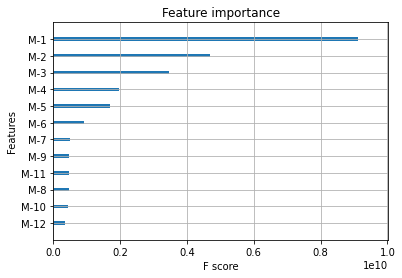

In [92]:
XGB.get_booster().feature_names = [f'M{x-12}' for x in range(12)]
xgb.plot_importance(XGB, importance_type='total_gain', show_values=False)

## XGBoost Multiple Periods

An evaluation set is a set of data that is left aside from the training set to be used as a monitoring dataset during the training.
- A validation set (random subset of the training set)
- A holdout set (last period of the training set) can be used as an evaluation set.

In [94]:
from sklearn.multioutput import MultiOutputRegressor
# Training and testing
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=6, test_loops=12)
XGB = XGBRegressor(n_jobs=1, max_depth=10, n_estimators=100, learning_rate=0.2)
multi = MultiOutputRegressor(XGB, n_jobs=-1)
multi.fit(X_train, Y_train)

# Future forecast
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=6, test_loops=0)
XGB = XGBRegressor(n_jobs=-1, max_depth=10, n_estimators=100, learning_rate=0.2)
multi = MultiOutputRegressor(XGB, n_jobs=-1)
multi.fit(X_train, Y_train)
forecast = pd.DataFrame(data=multi.predict(X_test), index=df.index)
display(forecast)

,0,1,2,3,4,5
Product,,,,,,
Product 1,1498.645630,1578.775757,1420.201660,1462.191406,1388.918823,1254.685303
Product 10,823.818298,904.254089,836.072754,849.079041,962.027527,797.235657
Product 11,1155.405273,1053.113647,1006.534485,1070.520508,1016.833130,999.954041
Product 12,180.049591,177.706955,194.903534,204.816940,205.906830,238.992783
Product 13,296.075714,333.976166,264.437744,267.798584,273.175049,243.837997
...,...,...,...,...,...,...
Product 65,0.075331,0.091987,0.101166,0.127835,0.140862,0.171687
Product 66,18.125078,4.690122,15.028449,16.181410,15.141550,9.695789
Product 7,278.280151,332.045807,252.001617,334.966095,340.881256,224.178467


# XGBoost Stopping

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.15)

XGB = XGBRegressor(n_jobs=-1, max_depth=10, n_estimators=1000, learning_rate=0.01)
XGB = XGB.fit(x_train, y_train, early_stopping_rounds=100, verbose=True, eval_set=[(x_eval, y_eval)], eval_metric='mae')

# Playing with Evaluation Datasets

In [ ]:
XGB = XGB.fit(x_train, y_train, early_stopping_rounds=100, verbose=False,
    eval_set=[(x_train, y_train), (x_val, y_val)], eval_metric='mae', callbacks=[xgb.callback.print_evaluation(period=50)])

print(f'Best iteration: {XGB.get_booster().best_iteration}')
print(f'Best score: {XGB.get_booster().best_score}')

### You can also print the results on multiple metrics by passing a list of metrics to eval_metric.

In [ ]:
XGB = XGB.fit(x_train, y_train, early_stopping_rounds=100, verbose=False,
    eval_set=[(x_train, y_train), (x_val, y_val)], eval_metric=['rmse', 'mae'], callbacks= [xgb.callback.print_evaluation(period=50)])


### Going further: Instead of a validation set, you can also use a holdout dataset as the evaluation dataset. This can perform better on some datasets.

In [ ]:
X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test = datasets_holdout(df, x_len=12, y_len=1, test_loops=12, holdout_loops=12)

XGB = XGBRegressor(n_jobs=-1, max_depth=10, n_estimators=2000, learning_rate=0.01)
XGB = XGB.fit(X_train, Y_train, early_stopping_rounds=100, verbose=False, eval_set=[(X_holdout, Y_holdout)], eval_metric='mae')

### Multiple Periods and Early Stopping

In [ ]:
fit_params = {'early_stopping_rounds': 25,
            'eval_set': [(x_val, y_val)],
            'eval_metric': 'mae',
            'verbose': False}

XGB = XGBRegressor(n_jobs=1, max_depth=10, n_estimators=100, learning_rate=0.2)
multi = MultiOutputRegressor(XGB, n_jobs=-1)
multi.fit(X_train, Y_train, **fit_params)

# XGBoost Optimization

In [ ]:
params = {'max_depth': [5, 6, 7, 8, 10, 11],
        'learning_rate': [0.005, 0.01, 0.025, 0.05, 0.1, 0.15],
        'colsample_bynode': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], #max_features
        'colsample_bylevel': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],#max_samples
        'min_child_weight': [5, 10, 15, 20, 25],#min_samples_leaf
        'reg_alpha': [1, 5, 10, 20, 50],
        'reg_lambda': [0.01, 0.05, 0.1, 0.5, 1],
        'n_estimators':[1000]}

fit_params = fit_params = {'early_stopping_rounds': 25,
            'eval_set': [(x_val, y_val)],
            'eval_metric': 'mae',
            'verbose': False}

XGB = XGBRegressor(n_jobs=1)
XGB_cv = RandomizedSearchCV(XGB, params, cv=5, n_jobs=-1, verbose=1,
    n_iter=1000, scoring='neg_mean_absolute_error')
XGB_cv.fit(x_train, y_train, **fit_params)

# Pro-Tip - Faster Search
If you want to speed up your optimization process, you can try to decrease the number of trees while running your random search. Once you find a good set of parameters, you can then increase the number of trees while decreasing the learning rate, until you find a sweet spot.

In [ ]:
# We can run a XGBoost with those optimal parameters
best_params = XGB_cv.best_params_
XGB = XGBRegressor(n_jobs=-1, **best_params)
XGB = XGB.fit(x_train, y_train, **fit_params)
print(f'Best iteration: {XGB.get_booster().best_iteration}')
print(f'Best score: {XGB.get_booster().best_score}')
Y_train_pred = XGB.predict(X_train)
Y_test_pred = XGB.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='XGBoost')

# Clustering

In [5]:
# Seasonal factors
def seasonal_factors(df, slen):
    s = pd.DataFrame(index=df.index)
    for i in range(slen):
        s[i+1] = df.iloc[:, i::slen].mean(axis=1)
    s = s.divide(s.mean(axis=1), axis=0).fillna(0)
    return s

# Return the seasonality factors scaled with a range of 1 and a mean of 0
def scaler(s):
    mean = s.mean(axis=1)
    maxi = s.max(axis=1)
    mini = s.min(axis=1)
    s = s.subtract(mean, axis=0)
    s = s.divide(maxi-mini, axis=0).fillna(0)
    return s

df = import_data()
s = seasonal_factors(df, slen=12)
s = scaler(s)
print(s.head())

                  1         2         3         4         5         6   \
Product                                                                  
Product 1   0.288605  0.011695  0.164371 -0.095635  0.042850 -0.136903   
Product 10 -0.007418 -0.378734 -0.257876  0.002033  0.207361 -0.225387   
Product 11  0.244091 -0.259060 -0.057379  0.058692 -0.000657 -0.072610   
Product 12 -0.198136 -0.335696  0.055094 -0.115959  0.247199  0.623515   
Product 13  0.591144  0.078246  0.147291  0.051763  0.014875 -0.407911   

                  7         8         9         10        11        12  
Product                                                                 
Product 1   0.086075  0.151158  0.144797  0.174158 -0.119776 -0.711395  
Product 10 -0.118175  0.031923 -0.038253 -0.067493  0.230753  0.621266  
Product 11 -0.513262 -0.131434  0.007222  0.344932  0.486738 -0.107274  
Product 12 -0.034380  0.137988 -0.226485  0.332725 -0.109380 -0.376485  
Product 13 -0.184695 -0.057008  0.066896  0

/var/folders/zb/60dzf9rs2g5dzbn8q93wz0hw0000gn/T/ipykernel_11026/4217060415.py:4: ConvergenceWarning: Number of distinct clusters (63) found smaller than n_clusters (64). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n, random_state=0).fit(s)
/var/folders/zb/60dzf9rs2g5dzbn8q93wz0hw0000gn/T/ipykernel_11026/4217060415.py:4: ConvergenceWarning: Number of distinct clusters (63) found smaller than n_clusters (65). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n, random_state=0).fit(s)
/var/folders/zb/60dzf9rs2g5dzbn8q93wz0hw0000gn/T/ipykernel_11026/4217060415.py:4: ConvergenceWarning: Number of distinct clusters (63) found smaller than n_clusters (66). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n, random_state=0).fit(s)


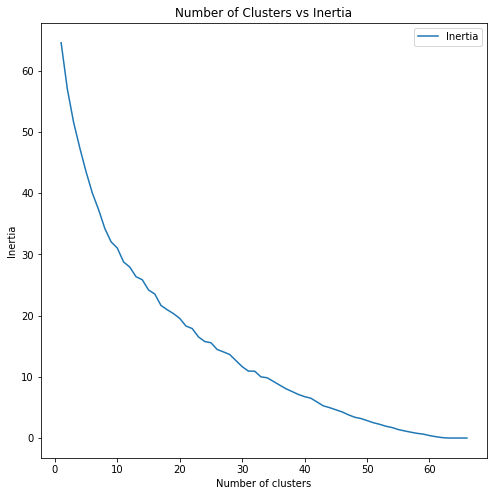

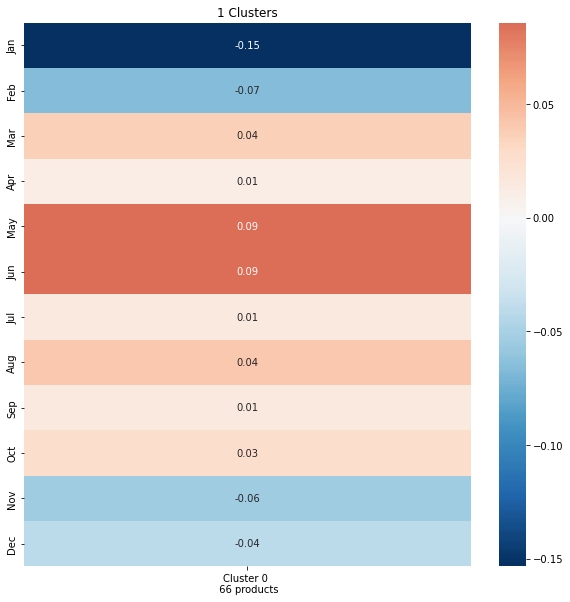

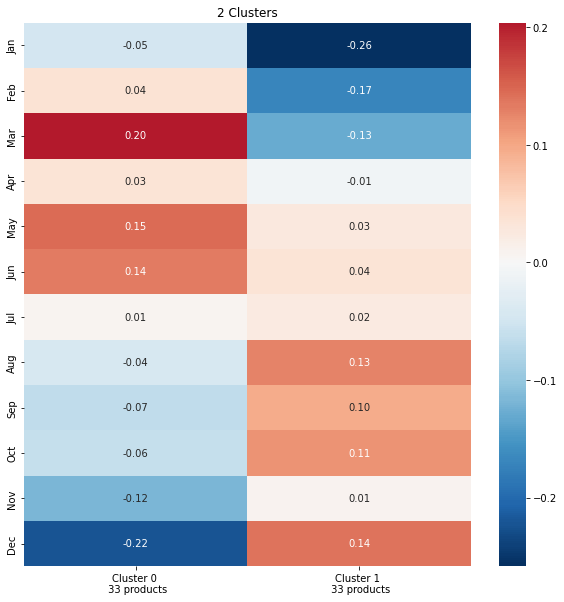

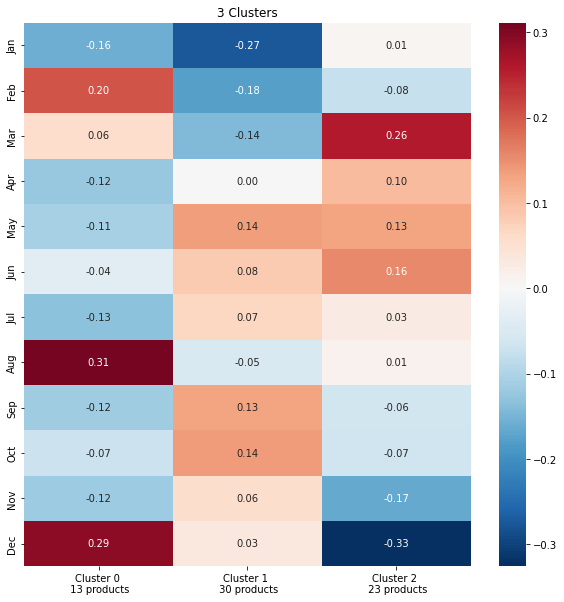

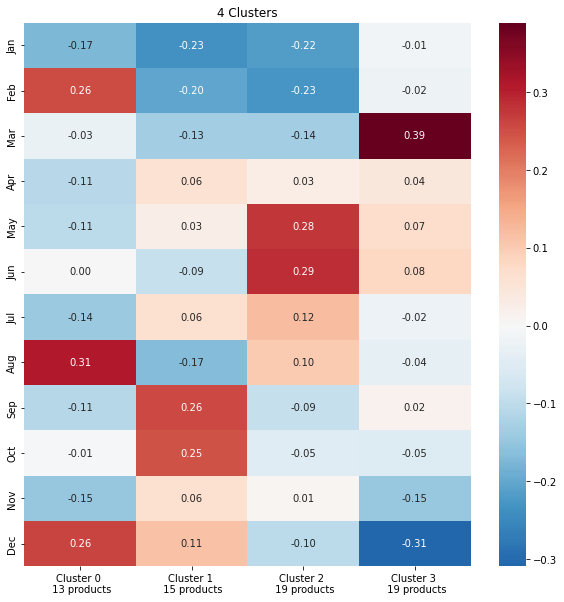

In [7]:
# Inertia Visualization
results = []
for n in range(1, 67):
    kmeans = KMeans(n_clusters=n, random_state=0).fit(s)
    results.append([n, kmeans.inertia_])
results = pd.DataFrame(data=results, columns=['Number of clusters', 'Inertia']).set_index('Number of clusters')
results.plot(figsize=(8,8))
plt.ylabel('Inertia')
plt.title('Number of Clusters vs Inertia')

import calendar
import seaborn as sns

for n in range(1,5):
    # Cluster Visualization
    kmeans = KMeans(n_clusters=n, random_state=0).fit(s)
    df['Group'] = kmeans.predict(s)
    cluster_products = df['Group'].value_counts().sort_index()

    # Cluster Visualization
    kmeans = KMeans(n_clusters=n, random_state=0).fit(s)
    centers = pd.DataFrame(data=kmeans.cluster_centers_).transpose()
    centers.index = calendar.month_abbr[1:]
    centers.columns = [f'Cluster {x} \n {cluster_products[x]} products' for x in range(centers.shape[1])]

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(centers, annot=True, fmt='.2f', center=0, cmap='RdBu_r', ax=ax)
    plt.title(f'{n} Clusters')

Period,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
Product,,,,,,,,,,,,,,,,,,,,,
Product 12,263,247,239,179,223,277,281,288,184,202,...,146,155,117,175,162,149,171,161,119,163
Product 15,169,175,243,191,241,195,204,103,220,234,...,0,0,0,0,0,0,0,0,0,0
Product 2,2521,1517,1428,1257,1934,1531,1777,1665,1373,1941,...,3017,2222,2287,2076,2359,2084,2161,2106,2239,1688
Product 20,55,119,171,92,169,159,137,122,158,145,...,376,349,373,339,401,418,315,343,327,422
Product 22,26,32,28,31,30,37,28,24,26,26,...,53,80,127,97,79,48,56,78,68,65
Product 29,9,6,20,7,18,10,12,23,32,28,...,14,7,5,3,19,16,10,12,32,3
Product 30,4,5,3,11,8,5,5,1,4,4,...,0,0,0,0,0,0,0,0,0,0
Product 31,4,0,5,5,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Product 32,3,5,9,5,5,8,12,5,5,7,...,18,38,46,23,42,44,34,33,38,27


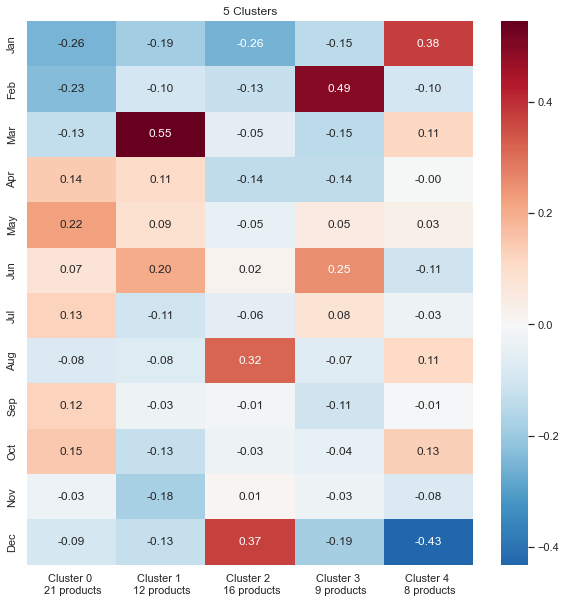

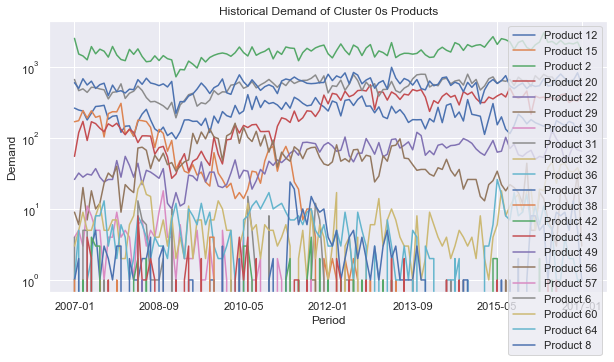

In [13]:
from sklearn.cluster import KMeans
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(s)
df['Group'] = kmeans.predict(s)
cluster_products = df['Group'].value_counts().sort_index()

# Cluster Visualization
import calendar
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(s)
centers = pd.DataFrame(data=kmeans.cluster_centers_).transpose()
centers.index = calendar.month_abbr[1:]
centers.columns = [f'Cluster {x} \n {cluster_products[x]} products' for x in range(centers.shape[1])]

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(centers, annot=True, fmt='.2f', center=0, cmap='RdBu_r', ax=ax)
plt.title(f'{n_clusters} Clusters')

# Return the list of Cluster x's products
cluster_index = 0
cluster_products = df[df['Group']==cluster_index].drop(columns=['Group'])
display(cluster_products)

# Plot the demand of Cluster x's products
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(10,5))

for i in range(len(cluster_products.index)):
    cluster_products.iloc[i, :].plot()

plt.yscale('log')
plt.ylabel("Demand")
plt.title(f'Historical Demand of Cluster {cluster_index}s Products')
plt.legend()
plt.show()
